In [1]:
#Set up the Run Engine enviroment that will run the plan

from bluesky.run_engine import RunEngine 

RE = RunEngine({})


#Set up plotting
from bluesky.callbacks.best_effort import BestEffortCallback
from event_model import RunRouter


def bec_factory(name, doc):
    # Documents from each run is routed to an independent
    #   instance of BestEffortCallback
    bec = BestEffortCallback()
    return [bec], []
bec_rr = RunRouter([bec_factory])
RE.subscribe(bec_rr)

0

In [14]:
det.noise.set(1)

Status(obj=EnumSignal(name='det_noise', parent='det', value=1, timestamp=1678192239.260652), done=False, success=False)

In [24]:
import bluesky.preprocessors as bpp
from bluesky.utils import Msg
import numpy as np

import bluesky.plan_stubs as bps

def tune_to_max(
        detectors, signal, motor,
        start, stop, min_step,
        num=10,
        step_factor=3.0,
        snake=False,
        *, md=None):
    r"""
    plan: tune a motor to the centroid of signal(motor)

    Initially, traverse the range from start to stop with
    the number of points specified.  Repeat with progressively
    smaller step size until the minimum step size is reached.
    Rescans will be centered on maximum of the previous pass

    Set ``snake=True`` if your positions are reproducible
    moving from either direction.  This will not necessarily
    decrease the number of traversals required to reach convergence.
    Snake motion reduces the total time spent on motion
    to reset the positioner.  For some positioners, such as
    those with hysteresis, snake scanning may not be appropriate.
    For such positioners, always approach the positions from the
    same direction.

    Note:  Ideally the signal has only one peak in the range to
    be scanned.  It is assumed the signal is not polymodal
    between ``start`` and ``stop``.

    Parameters
    ----------
    detectors : Signal
        list of 'readable' objects
    signal : string
        detector field whose output is to maximize
    motor : object
        any 'settable' object (motor, temp controller, etc.)
    start : float
        start of range
    stop : float
        end of range, note: start < stop
    min_step : float
        smallest step size to use.
    num : int, optional
        number of points with each traversal, default = 10
    step_factor : float, optional
        used in calculating new range after each pass

        note: step_factor > 1.0, default = 3
    snake : bool, optional
        if False (default), always scan from start to stop
    md : dict, optional
        metadata

    Examples
    --------
    Find the center of a peak using synthetic hardware.

    >>> from ophyd.sim import SynAxis, SynGauss
    >>> motor = SynAxis(name='motor')
    >>> det = SynGauss(name='det', motor, 'motor',
    ...                center=-1.3, Imax=1e5, sigma=0.05)
    >>> RE(tune_centroid([det], "det", motor, -1.5, -0.5, 0.01, 10))
    """
    if min_step <= 0:
        raise ValueError("min_step must be positive")
    if step_factor <= 1.0:
        raise ValueError("step_factor must be greater than 1.0")
    try:
        motor_name, = motor.hints['fields']
    except (AttributeError, ValueError):
        motor_name = motor.name
    _md = {'detectors': [det.name for det in detectors],
           'motors': [motor.name],
           'plan_args': {'detectors': list(map(repr, detectors)),
                         'motor': repr(motor),
                         'start': start,
                         'stop': stop,
                         'num': num,
                         'min_step': min_step, },
           'plan_name': 'tune_centroid',
           'hints': {},
           }
    _md.update(md or {})
    try:
        dimensions = [(motor.hints['fields'], 'primary')]
    except (AttributeError, KeyError):
        pass
    else:
        _md['hints'].setdefault('dimensions', dimensions)

    low_limit = min(start, stop)
    high_limit = max(start, stop)

    @bpp.stage_decorator(list(detectors) + [motor])
    @bpp.run_decorator(md=_md)
    def _tune_core(start, stop, num, signal):
        next_pos = start
        step = (stop - start) / (num - 1)
        peak_position = None
        cur_I = None
        sum_I = 0       # for peak centroid calculation, I(x)
        sum_xI = 0
        max = 0
        max_pos = 0

        while abs(step) >= min_step and low_limit <= next_pos <= high_limit:
            yield Msg('checkpoint')
            yield from bps.mv(motor, next_pos)
            ret = (yield from bps.trigger_and_read(detectors + [motor]))
            cur_I = ret[signal]['value']
            if cur_I > max:
                max = cur_I
                max_pos = next_pos
            sum_I += cur_I
            position = ret[motor_name]['value']
            sum_xI += position * cur_I

            next_pos += step
            in_range = min(start, stop) <= next_pos <= max(start, stop)

            if not in_range:
                if sum_I == 0:
                    return
                peak_position = max_pos  # centroid
                max = 0
                max_pos = 0
                sum_I, sum_xI = 0, 0    # reset for next pass
                new_scan_range = (stop - start) / step_factor
                start = np.clip(peak_position - new_scan_range/2,
                                low_limit, high_limit)
                stop = np.clip(peak_position + new_scan_range/2,
                               low_limit, high_limit)
                if snake:
                    start, stop = stop, start
                step = (stop - start) / (num - 1)
                next_pos = start
                print("peak position = {}".format(peak_position))
                print("start = {}".format(start))
                print("stop = {}".format(stop))

        # finally, move to peak position
        if peak_position is not None:
            # improvement: report final peak_position
            print("final position = {}".format(peak_position))
            yield from bps.mv(motor, peak_position)

    return (yield from _tune_core(start, stop, num, signal))



Transient Scan ID: 13     Time: 2023-03-07 13:49:19
Persistent Unique Scan ID: '77dd1fee-7249-42d5-9f73-867af23b3b15'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |        det |
+-----------+------------+------------+------------+
|         1 | 13:49:19.8 |        160 |      0.616 |
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 
 failed to format row 


Run aborted
Traceback (most recent call last):
  File "/home/emil/Apps/dev/sissy_profile_dev/.venv/lib/python3.8/site-packages/bluesky/run_engine.py", line 1365, in _run
    msg = self._plan_stack[-1].send(resp)
  File "/tmp/ipykernel_4080064/4245352726.py", line 147, in tune_centroid
    return (yield from _tune_core(start, stop, num, signal))
  File "/home/emil/Apps/dev/sissy_profile_dev/.venv/lib/python3.8/site-packages/bluesky/utils/__init__.py", line 1140, in dec_inner
    return (yield from plan)
  File "/home/emil/Apps/dev/sissy_profile_dev/.venv/lib/python3.8/site-packages/bluesky/preprocessors.py", line 952, in stage_wrapper
    return (yield from finalize_wrapper(inner(), unstage_devices()))
  File "/home/emil/Apps/dev/sissy_profile_dev/.venv/lib/python3.8/site-packages/bluesky/preprocessors.py", line 509, in finalize_wrapper
    ret = yield from plan
  File "/home/emil/Apps/dev/sissy_profile_dev/.venv/lib/python3.8/site-packages/bluesky/preprocessors.py", line 950, in inner


+-----------+------------+------------+------------+
generator tune_centroid ['77dd1fee'] (scan num: 13)





NameError: name 'np' is not defined

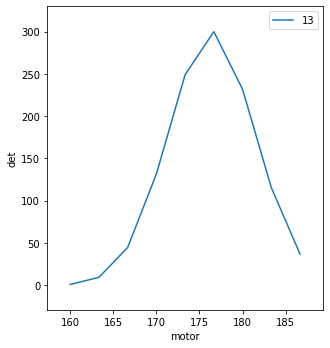

In [25]:
from ophyd.sim import SynAxis, SynGauss
motor = SynAxis(name='motor')
det = SynGauss('det', motor, 'motor', center=176.4, Imax=300, sigma=5,noise="uniform",noise_multiplier = 1)

RE(tune_centroid([det], "det", motor,160, 190, 0.01, 10))

In [7]:
motor.get()

SynAxisTuple(readback=-0.8331284584547861, setpoint=-0.8331284584547861, velocity=1, acceleration=1, unused=1)